# Train A Shape Classifier Model



In [1]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) #tenshor shape: (batch_size, 1, 64, 64) to tensor shape: (batch_size, 16, 32, 32)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #tenshor shape: (batch_size, 16, 32, 32) to tensor shape: (batch_size, 32, 16, 16)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [3]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1007, Accuracy: 0.00%
Epoch [2/15], Loss: 0.9940, Accuracy: 0.00%
Epoch [3/15], Loss: 0.9025, Accuracy: 0.00%
Epoch [4/15], Loss: 0.7319, Accuracy: 0.00%
Epoch [5/15], Loss: 0.5177, Accuracy: 0.00%
Epoch [6/15], Loss: 0.3261, Accuracy: 0.00%
Epoch [7/15], Loss: 0.2105, Accuracy: 0.00%
Epoch [8/15], Loss: 0.1368, Accuracy: 0.00%
Epoch [9/15], Loss: 0.0714, Accuracy: 0.00%
Epoch [10/15], Loss: 0.0376, Accuracy: 0.00%
Epoch [11/15], Loss: 0.0223, Accuracy: 0.00%
Epoch [12/15], Loss: 0.0141, Accuracy: 0.00%
Epoch [13/15], Loss: 0.0099, Accuracy: 0.00%
Epoch [14/15], Loss: 0.0075, Accuracy: 0.00%
Epoch [15/15], Loss: 0.0053, Accuracy: 0.00%


# Test 

In [5]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def test(model, test_loader):
    model.eval()
    all_labels = [] 
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    #Calculate precision, recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

    def safe_iter(x):
        #if salar, covnert to 1-element list for iteration
        if np.isscalar(x):
            return [x]
        return x
    precision = safe_iter(precision)
    recall = safe_iter(recall)
    f1 = safe_iter(f1)

    for i, (p, r ,f) in enumerate(zip(precision, recall, f1)):
        print(f'Class {i} - Precision: {p:.4f}, Recall: {r:.4f}, F1-score: {f:.4f}')
    
    #Calculate and print overall macro averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    print(f'Macro Average - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}')

test(model, test_loader)

Class 0 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 1 - Precision: 0.7527, Recall: 0.6731, F1-score: 0.7107
Class 2 - Precision: 0.9697, Recall: 0.9057, F1-score: 0.9366
Macro Average - Precision: 0.7964, Recall: 0.7929, F1-score: 0.7915


# Show Predictions


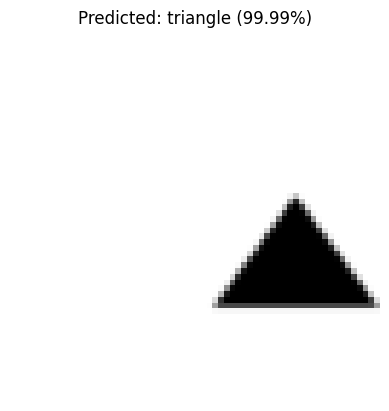

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

#Class names matching your dataset folder order
class_names = ['circle', 'diamond', 'triangle']
def show_prediction(model, image):
    model.eval()

    #Add batch dimension if missing
    if image.dim() == 3:
        image = image.unsqueeze(0) #shape [1, C, H, W]

    with torch.no_grad():
        outputs = model(image.to(device))
        probs = F.softmax(outputs, dim=1) #convert logits to probabilities
        conf, pred_idx = torch.max(probs, 1)

    #Convert tensor to CPU numpy array for plotting
    img_np = image.squeeze().cpu().numpy()

    #Plot Image
    plt.imshow(img_np, cmap='gray')
    plt.axis('off')

    # Prepare texit with prediction and confidence %
    label = class_names[pred_idx.item()]
    confidence = conf.item() * 100
    title = f'Predicted: {label} ({confidence:.2f}%)'
    plt.title(title)

image, label = test_dataset[298]
show_prediction(model, image)
